# More locally stable models on examples pulled from the dysts database of chaotic systems + bonus: best reduced-order models to-date for the lid-cavity flow
Here we test the locally stable trapping theorem on additional systems from the dysts database, https://github.com/williamgilpin/dysts, that (in principle) satisfy the totally-symmetric quadratic coefficient constraint. The locally stable trapping method allows the quadratic models to deviate from being totally symmetric by a small amount. These deviations are caused by finite data, noise, or imperfect optimization.

In [1]:
import warnings

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from trapping_utils import check_local_stability
from trapping_utils import integrator_keywords
from trapping_utils import load_data
from trapping_utils import make_trap_progress_plots
from trapping_utils import obj_function
from trapping_utils import sindy_library

import pysindy as ps

# ignore warnings
warnings.filterwarnings("ignore")
np.random.seed(1)

The local stability version of Trapping SINDy reduces to the following unconstrained optimization problem:
$$\text{argmin}_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta^{-1} \lambda_1(\mathbf A) + \alpha^{-1}\|Q_{ijk}\| + \beta^{-1}\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We now solve this problem for $\beta \ll \alpha$.

A conservative estimate of the local stability is:
$$\rho_+ = \frac{3|\lambda_{\text{max}}|}{2r^{\frac{3}{2}}\epsilon_Q} \left( 1 + \sqrt{1 - \frac{4r^{\frac{3}{2}}\epsilon_Q}{3\lambda^2_{\text{max}}(\textbf{A}_S)\|\mathbf{d}\|_2}} \right).$$
And the radius of the trapping region is given by:
$$\rho_- = \frac{3|\lambda_{\text{max}}|}{2r^{\frac{3}{2}}\epsilon_Q} \left( 1 - \sqrt{1 - \frac{4r^{\frac{3}{2}}\epsilon_Q}{3\lambda^2_{\text{max}}(\textbf{A}_S)\|\mathbf{d}\|_2}} \right).$$

### Dysts database contains a number of quadratically nonlinear chaotic systems with the special energy-preserving nonlinear symmetry.
You will need to install the dysts database with 'pip install dysts' or similar command (see https://github.com/williamgilpin/dysts) in order to load in the data.

In [2]:
import dysts.flows as flows

# List below picks out the polynomially nonlinear systems that are quadratic and
# exhibit the special structure in the quadratic coefficients.
trapping_system_list = np.array(
    [2, 3, 7, 10, 18, 24, 27, 29, 30, 34, 40, 46, 47, 66, 67]
)
systems_list = [
    "Aizawa",
    "Bouali2",
    "GenesioTesi",
    "HyperBao",
    "HyperCai",
    "HyperJha",
    "HyperLorenz",
    "HyperLu",
    "HyperPang",
    "Laser",
    "Lorenz",
    "LorenzBounded",
    "MooreSpiegel",
    "Rossler",
    "ShimizuMorioka",
    "HenonHeiles",
    "GuckenheimerHolmes",
    "Halvorsen",
    "KawczynskiStrizhak",
    "VallisElNino",
    "RabinovichFabrikant",
    "NoseHoover",
    "Dadras",
    "RikitakeDynamo",
    "NuclearQuadrupole",
    "PehlivanWei",
    "SprottTorus",
    "SprottJerk",
    "SprottA",
    "SprottB",
    "SprottC",
    "SprottD",
    "SprottE",
    "SprottF",
    "SprottG",
    "SprottH",
    "SprottI",
    "SprottJ",
    "SprottK",
    "SprottL",
    "SprottM",
    "SprottN",
    "SprottO",
    "SprottP",
    "SprottQ",
    "SprottR",
    "SprottS",
    "Rucklidge",
    "Sakarya",
    "RayleighBenard",
    "Finance",
    "LuChenCheng",
    "LuChen",
    "QiChen",
    "ZhouChen",
    "BurkeShaw",
    "Chen",
    "ChenLee",
    "WangSun",
    "DequanLi",
    "NewtonLiepnik",
    "HyperRossler",
    "HyperQi",
    "Qi",
    "LorenzStenflo",
    "HyperYangChen",
    "HyperYan",
    "HyperXu",
    "HyperWang",
    "Hadley",
]
alphabetical_sort = np.argsort(systems_list)
systems_list = (np.array(systems_list)[alphabetical_sort])[trapping_system_list]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "lyapunov_spectrum_estimated",
    "embedding_dimension",
    "parameters",
    "dt",
    "hamiltonian",
    "period",
    "unbounded_indices",
]

# Get attributes
all_properties = dict()
for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))

# Get training and testing trajectories for all the experimental systems
n = 1000  # Trajectories with 1000 points
pts_per_period = 100  # sampling with 100 points per period
# generate n_trajectories starting from different initial conditions on the attractor
n_trajectories = 1
all_sols_train, all_t_train, all_sols_test, all_t_test = load_data(
    systems_list,
    all_properties,
    n=n,
    pts_per_period=pts_per_period,
    random_bump=False,  # optionally start with initial conditions pushed slightly off the attractor
    # optionally do high-resolution sampling at rate proportional to the dt parameter
    include_transients=False,
    n_trajectories=n_trajectories,
)

0 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)


1 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)


2 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)


3 Hadley(name='Hadley', params={'a': 0.2, 'b': 4, 'f': 9, 'g': 1}, random_state=None)


4 HyperPang(name='HyperPang', params={'a': 36, 'b': 3, 'c': 20, 'd': 2}, random_state=None)


5 HyperYangChen(name='HyperYangChen', params={'a': 30, 'b': 3, 'c': 35, 'd': 8}, random_state=None)


6 Lorenz(name='Lorenz', params={'beta': 2.667, 'rho': 28, 'sigma': 10}, random_state=None)


7 LorenzStenflo(name='LorenzStenflo', params={'a': 2, 'b': 0.7, 'c': 26, 'd': 1.5}, random_state=None)


8 LuChen(name='LuChen', params={'a': 36, 'b': 3, 'c': 18}, random_state=None)


9 NoseHoover(name='NoseHoover', params={'a': 1.5}, random_state=None)


10 RayleighBenard(name='RayleighBenard', params={'a': 30, 'b': 5, 'r': 18}, random_state=None)


11 SprottA(name='SprottA', params={}, random_state=None)


12 SprottB(name='SprottB', params={}, random_state=None)


13 SprottTorus(name='SprottTorus', params={}, random_state=None)


14 VallisElNino(name='VallisElNino', params={'b': 102, 'c': 3, 'p': 0}, random_state=None)


#### Get some more information about the dynamical systems and their true equation coefficients

In [3]:
from dysts.equation_utils import make_dysts_true_coefficients

num_attractors = len(systems_list)

# Calculate some dynamical properties
lyap_list = []
dimension_list = []
param_list = []

# Calculate various definitions of scale separation
scale_list_avg = []
scale_list = []
linear_scale_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]["maximum_lyapunov_estimated"])
    dimension_list.append(all_properties[system]["embedding_dimension"])
    param_list.append(all_properties[system]["parameters"])

    # Ratio of dominant (average) to smallest timescales
    scale_list_avg.append(
        all_properties[system]["period"] / all_properties[system]["dt"]
    )


# Get the true coefficients for each system
true_coefficients = make_dysts_true_coefficients(
    systems_list, all_sols_train, dimension_list, param_list
)

### Issues with using the trapping theorem with some of the dysts systems
The trapping theorem and its variants require that systems are "effectively nonlinear", meaning there are no *invariant* linear subspaces where the system trajectories can escape to infinity.

It turns out that Burke-Shaw, NoseHoover, SprottTorus, SprottA and SprottB are all not effectively nonlinear and exhibit subspaces where one of the coordinates can grow indefinitely! This is a good thing that the trapping theorem doesn't work for them -- these systems are *not* globally stable after all.

Actually, SprottTorus has no cubic terms in the energy at all (so the trapping theorem is thwarted), and is very challenging to evaluate the boundedness. However, numerical results seem to point to it being bounded for all practical purposes (https://sprott.physics.wisc.edu/pubs/paper423.pdf).

HyperPang, Chen, HyperYangChen, RayleighBernard, LuChen also not effectively nonlinear, but have stable linear (invariant) subspaces, usually (x=0, y=0, z, ...). Extending the trapping theorem to address these cases of global stability is work in progress.

Finally, the systems that do work with the trapping theorem: Finance, Hadley, Lorenz, LorenzStenFlo, VallisElNino.

We will illustrate how each of these systems produces a negative definite $\mathbf{A}^S$ matrix or "gets stuck" before this happens, which indicates a lack of effective nonlinearity and potential for unboundedness.

*We use simulated annealing to show this with the analytic systems below, and we also fit Trapping SINDy models for each.*

0 BurkeShaw
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.374e+01 ... 5.800e-03 ... 0.00e+00 ... 4.92e-19 ... 2.23e-48 ... 1.37e+01
  500 ... 1.374e+01 ... 6.520e-04 ... 0.00e+00 ... 4.92e-19 ... 5.54e-48 ... 1.37e+01


 1000 ... 1.374e+01 ... 6.519e-04 ... 0.00e+00 ... 4.92e-19 ... 1.05e-47 ... 1.37e+01
 1500 ... 1.374e+01 ... 6.519e-04 ... 0.00e+00 ... 4.92e-19 ... 1.03e-47 ... 1.37e+01


 2000 ... 1.374e+01 ... 6.519e-04 ... 0.00e+00 ... 4.92e-19 ... 1.02e-47 ... 1.37e+01
 2500 ... 1.374e+01 ... 6.518e-04 ... 0.00e+00 ... 4.92e-19 ... 3.28e-47 ... 1.37e+01


 3000 ... 1.374e+01 ... 6.518e-04 ... 0.00e+00 ... 4.92e-19 ... 1.08e-47 ... 1.37e+01
 3500 ... 1.374e+01 ... 6.518e-04 ... 0.00e+00 ... 4.92e-19 ... 1.73e-47 ... 1.37e+01


 4000 ... 1.374e+01 ... 6.518e-04 ... 0.00e+00 ... 4.92e-19 ... 6.52e-48 ... 1.37e+01
 4500 ... 1.374e+01 ... 6.517e-04 ... 0.00e+00 ... 4.92e-19 ... 4.85e-48 ... 1.37e+01


optimal m:  [-1.34437152 -0.00427584 -0.99491814]
As eigvals:  [-9.94804601 -0.01061302  1.0381609 ]
Maximum deviation from having zero totally symmetric part:  3.099950851570554e-14
Estimate of trapping region size, Rm =  -19335225161624.2
Local stability size, R_ls=  -22.0813377492594
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  1.0000000000000002
1 Chen
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.242e+02 ... 4.967e-01 ... 0.00e+00 ... 4.86e-21 ... 1.61e-48 ... 2.25e+02


  500 ... 2.245e+02 ... 3.954e-01 ... 0.00e+00 ... 4.86e-21 ... 2.13e-48 ... 2.25e+02
 1000 ... 2.246e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 4.40e-48 ... 2.25e+02


 1500 ... 2.247e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 2.09e-48 ... 2.25e+02
 2000 ... 2.247e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 1.41e-47 ... 2.25e+02
 2500 ... 2.247e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 8.51e-48 ... 2.25e+02


 3000 ... 2.247e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 7.86e-48 ... 2.25e+02
 3500 ... 2.247e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 1.24e-48 ... 2.25e+02
 4000 ... 2.247e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 2.71e-48 ... 2.25e+02


 4500 ... 2.247e+02 ... 3.941e-01 ... 0.00e+00 ... 4.85e-21 ... 8.67e-48 ... 2.25e+02


optimal m:  [-1.3573768  -0.52627824 28.67208327]
As eigvals:  [-34.87529829  -2.99694538  27.97367506]
Maximum deviation from having zero totally symmetric part:  1.9343901480617376e-14
Estimate of trapping region size, Rm =  -834919927859932.
Local stability size, R_ls=  -3.44618724036064
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  28.00000000108929
2 Finance
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 8.059e-02 ... 1.038e-02 ... 0.00e+00 ... 7.28e-21 ... 1.58e-48 ... 9.10e-02


  500 ... 8.066e-02 ... 4.648e-09 ... 0.00e+00 ... 7.28e-21 ... 2.81e-48 ... 8.07e-02


optimal m:  [-0.17768416 -5.18217413 -2.00036198]
As eigvals:  [-1.09407098 -0.26956504 -0.09953757]
Maximum deviation from having zero totally symmetric part:  1.011603995015875e-14
Estimate of trapping region size, Rm =  32.6424921808962
Local stability size, R_ls=  5680883410665.67
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.1999999999999495
3 Hadley
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.375e-02 ... 5.441e-03 ... 0.00e+00 ... 9.46e-20 ... 2.57e-49 ... 1.92e-02


optimal m:  [-1.33751325 -0.06398727 -0.22206423]
As eigvals:  [-2.435228   -2.33494431 -0.09947574]
Maximum deviation from having zero totally symmetric part:  4.701181935060084e-15
Estimate of trapping region size, Rm =  21.9789824010905
Local stability size, R_ls=  12216575901464.3
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.19999999999998988
4 HyperPang
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.376e+02 ... 3.374e-01 ... 0.00e+00 ... 4.84e-21 ... 4.67e-45 ... 1.38e+02


  500 ... 1.376e+02 ... 2.045e-01 ... 0.00e+00 ... 4.84e-21 ... 1.97e-45 ... 1.38e+02


 1000 ... 1.376e+02 ... 2.009e-01 ... 0.00e+00 ... 4.84e-21 ... 3.79e-45 ... 1.38e+02


 1500 ... 1.376e+02 ... 2.008e-01 ... 0.00e+00 ... 4.84e-21 ... 1.21e-45 ... 1.38e+02


 2000 ... 1.376e+02 ... 2.008e-01 ... 0.00e+00 ... 4.84e-21 ... 1.74e-45 ... 1.38e+02


 2500 ... 1.376e+02 ... 2.008e-01 ... 0.00e+00 ... 4.84e-21 ... 1.05e-45 ... 1.38e+02


 3000 ... 1.376e+02 ... 2.008e-01 ... 0.00e+00 ... 4.84e-21 ... 2.02e-45 ... 1.38e+02


 3500 ... 1.376e+02 ... 2.008e-01 ... 0.00e+00 ... 4.84e-21 ... 6.96e-46 ... 1.38e+02


 4000 ... 1.376e+02 ... 2.008e-01 ... 0.00e+00 ... 4.84e-21 ... 2.06e-45 ... 1.38e+02


 4500 ... 1.376e+02 ... 2.008e-01 ... 0.00e+00 ... 4.84e-21 ... 2.00e-45 ... 1.38e+02


optimal m:  [-1.03700662 -0.38332795 36.83646896  0.96097455]
As eigvals:  [-3.59163204e+01 -2.99632066e+00  1.58939709e-02  1.99371249e+01]
Maximum deviation from having zero totally symmetric part:  4.2146711468071807e-13
Estimate of trapping region size, Rm =  -17739039574290.3
Local stability size, R_ls=  -5.84947475759824
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  20.01249219725657
5 HyperYangChen
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.026e+02 ... 2.383e-01 ... 0.00e+00 ... 4.85e-21 ... 1.44e-45 ... 6.03e+02


  500 ... 6.027e+02 ... 1.208e-02 ... 0.00e+00 ... 4.85e-21 ... 8.14e-46 ... 6.03e+02


 1000 ... 6.028e+02 ... 2.744e-03 ... 0.00e+00 ... 4.85e-21 ... 3.18e-46 ... 6.03e+02


 1500 ... 6.029e+02 ... 1.177e-03 ... 0.00e+00 ... 4.85e-21 ... 5.35e-46 ... 6.03e+02


 2000 ... 6.029e+02 ... 7.013e-04 ... 0.00e+00 ... 4.85e-21 ... 3.02e-45 ... 6.03e+02


 2500 ... 6.030e+02 ... 5.096e-04 ... 0.00e+00 ... 4.85e-21 ... 5.55e-46 ... 6.03e+02


 3000 ... 6.030e+02 ... 4.187e-04 ... 0.00e+00 ... 4.85e-21 ... 1.41e-45 ... 6.03e+02


 3500 ... 6.030e+02 ... 3.711e-04 ... 0.00e+00 ... 4.85e-21 ... 5.40e-46 ... 6.03e+02


 4000 ... 6.030e+02 ... 3.444e-04 ... 0.00e+00 ... 4.85e-21 ... 9.20e-46 ... 6.03e+02


 4500 ... 6.030e+02 ... 3.287e-04 ... 0.00e+00 ... 4.85e-21 ... 3.97e-46 ... 6.03e+02


optimal m:  [-1.20403564 -0.06354667 59.24430709 -1.30016583]
As eigvals:  [-30.62877268  -2.99575385   0.29714886   0.59332826]
Maximum deviation from having zero totally symmetric part:  2.5963953209640067e-13
Estimate of trapping region size, Rm =  -856950007770.890
Local stability size, R_ls=  -308.505478646641
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  0.524174701772621
6 Lorenz
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.852e+02 ... 1.125e-01 ... 0.00e+00 ... 4.85e-21 ... 5.54e-47 ... 3.85e+02


  500 ... 3.852e+02 ... 2.121e-03 ... 0.00e+00 ... 4.85e-21 ... 8.38e-48 ... 3.85e+02
 1000 ... 3.852e+02 ... 1.718e-04 ... 0.00e+00 ... 4.85e-21 ... 8.51e-48 ... 3.85e+02


 1500 ... 3.852e+02 ... 2.629e-05 ... 0.00e+00 ... 4.85e-21 ... 9.94e-48 ... 3.85e+02
 2000 ... 3.852e+02 ... 5.124e-06 ... 0.00e+00 ... 4.85e-21 ... 4.37e-47 ... 3.85e+02
 2500 ... 3.852e+02 ... 1.107e-06 ... 0.00e+00 ... 4.85e-21 ... 1.06e-47 ... 3.85e+02


 3000 ... 3.852e+02 ... 2.505e-07 ... 0.00e+00 ... 4.85e-21 ... 2.31e-46 ... 3.85e+02
 3500 ... 3.852e+02 ... 5.796e-08 ... 0.00e+00 ... 4.85e-21 ... 4.73e-48 ... 3.85e+02
 4000 ... 3.852e+02 ... 1.355e-08 ... 0.00e+00 ... 4.85e-21 ... 3.33e-47 ... 3.85e+02


 4500 ... 3.852e+02 ... 3.184e-09 ... 0.00e+00 ... 4.85e-21 ... 1.97e-47 ... 3.85e+02


optimal m:  [-1.16303567 -0.15259968 32.11224102]
As eigvals:  [-10.75440138  -2.6607541   -0.09815079]
Maximum deviation from having zero totally symmetric part:  4.339237302808385e-14
Estimate of trapping region size, Rm =  874.504009680502
Local stability size, R_ls=  1305929568630.23
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.9999999999985182
7 LorenzStenflo
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.474e+01 ... 9.024e-02 ... 0.00e+00 ... 4.79e-21 ... 1.73e-45 ... 3.48e+01


  500 ... 3.478e+01 ... 7.573e-04 ... 0.00e+00 ... 4.79e-21 ... 1.23e-45 ... 3.48e+01


 1000 ... 3.479e+01 ... 9.173e-06 ... 0.00e+00 ... 4.79e-21 ... 1.11e-44 ... 3.48e+01


 1500 ... 3.480e+01 ... 1.388e-07 ... 0.00e+00 ... 4.79e-21 ... 3.83e-45 ... 3.48e+01


 2000 ... 3.480e+01 ... 2.188e-09 ... 0.00e+00 ... 4.79e-21 ... 8.28e-45 ... 3.48e+01


optimal m:  [-1.12601337 -0.04617752 25.47054576 -1.37929714]
As eigvals:  [-2.82687204 -1.82658495 -0.69767896 -0.09893107]
Maximum deviation from having zero totally symmetric part:  7.237613286470435e-13
Estimate of trapping region size, Rm =  182.559336800729
Local stability size, R_ls=  51258817605.8575
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.6999999998999133
8 LuChen
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 5.003e+03 ... 2.992e-01 ... 0.00e+00 ... 3.81e-21 ... 1.58e-45 ... 5.00e+03


  500 ... 5.007e+03 ... 1.545e-01 ... 0.00e+00 ... 3.75e-21 ... 6.05e-45 ... 5.01e+03
 1000 ... 5.014e+03 ... 1.433e-01 ... 0.00e+00 ... 3.70e-21 ... 1.30e-45 ... 5.01e+03


 1500 ... 5.019e+03 ... 1.413e-01 ... 0.00e+00 ... 3.68e-21 ... 2.36e-45 ... 5.02e+03
 2000 ... 5.021e+03 ... 1.407e-01 ... 0.00e+00 ... 3.66e-21 ... 2.79e-45 ... 5.02e+03
 2500 ... 5.022e+03 ... 1.404e-01 ... 0.00e+00 ... 3.66e-21 ... 3.03e-45 ... 5.02e+03


 3000 ... 5.023e+03 ... 1.402e-01 ... 0.00e+00 ... 3.65e-21 ... 4.21e-46 ... 5.02e+03
 3500 ... 5.024e+03 ... 1.401e-01 ... 0.00e+00 ... 3.65e-21 ... 8.59e-46 ... 5.02e+03


 4000 ... 5.024e+03 ... 1.399e-01 ... 0.00e+00 ... 3.65e-21 ... 7.87e-45 ... 5.02e+03
 4500 ... 5.025e+03 ... 1.398e-01 ... 0.00e+00 ... 3.64e-21 ... 7.86e-45 ... 5.02e+03


optimal m:  [ 1.67698575 -0.24752441 48.99558826]
As eigvals:  [-36.98130146  -2.95232853  16.61125046]
Maximum deviation from having zero totally symmetric part:  1.5787371410169726e-13
Estimate of trapping region size, Rm =  -60747984410482.2
Local stability size, R_ls=  -10.6992505581470
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  18.000000000939096
9 NoseHoover
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.694e-01 ... 1.463e-05 ... 0.00e+00 ... 7.37e-21 ... 1.74e-51 ... 6.69e-01


  500 ... 6.694e-01 ... 1.236e-05 ... 0.00e+00 ... 7.37e-21 ... 2.87e-51 ... 6.69e-01
 1000 ... 6.694e-01 ... 1.134e-05 ... 0.00e+00 ... 7.37e-21 ... 1.88e-51 ... 6.69e-01


 1500 ... 6.694e-01 ... 1.081e-05 ... 0.00e+00 ... 7.37e-21 ... 1.04e-51 ... 6.69e-01
 2000 ... 6.694e-01 ... 1.052e-05 ... 0.00e+00 ... 7.37e-21 ... 2.19e-51 ... 6.69e-01


 2500 ... 6.694e-01 ... 1.035e-05 ... 0.00e+00 ... 7.37e-21 ... 1.74e-50 ... 6.69e-01
 3000 ... 6.694e-01 ... 1.025e-05 ... 0.00e+00 ... 7.37e-21 ... 1.69e-51 ... 6.69e-01


 3500 ... 6.694e-01 ... 1.019e-05 ... 0.00e+00 ... 7.37e-21 ... 1.48e-51 ... 6.69e-01
 4000 ... 6.694e-01 ... 1.016e-05 ... 0.00e+00 ... 7.37e-21 ... 7.55e-51 ... 6.69e-01


 4500 ... 6.694e-01 ... 1.013e-05 ... 0.00e+00 ... 7.37e-21 ... 2.24e-51 ... 6.69e-01


optimal m:  [-1.16593683 -0.03982357 -1.99431913]
As eigvals:  [-1.97636056e+00 -1.05441196e-03  2.23094588e-03]
Maximum deviation from having zero totally symmetric part:  1.159976206461993e-16
Estimate of trapping region size, Rm =  -11103996766482.2
Local stability size, R_ls=  -865.444855254901
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  5.027434926710921e-14
10 RayleighBenard
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 4.262e+02 ... 2.641e-01 ... 0.00e+00 ... 4.80e-21 ... 6.70e-47 ... 4.27e+02


  500 ... 4.265e+02 ... 1.653e-01 ... 0.00e+00 ... 4.79e-21 ... 1.03e-46 ... 4.27e+02
 1000 ... 4.268e+02 ... 1.629e-01 ... 0.00e+00 ... 4.79e-21 ... 5.38e-46 ... 4.27e+02


 1500 ... 4.268e+02 ... 1.628e-01 ... 0.00e+00 ... 4.78e-21 ... 3.50e-46 ... 4.27e+02
 2000 ... 4.268e+02 ... 1.628e-01 ... 0.00e+00 ... 4.78e-21 ... 2.30e-46 ... 4.27e+02
 2500 ... 4.268e+02 ... 1.628e-01 ... 0.00e+00 ... 4.78e-21 ... 3.19e-46 ... 4.27e+02


 3000 ... 4.269e+02 ... 1.628e-01 ... 0.00e+00 ... 4.78e-21 ... 7.79e-47 ... 4.27e+02
 3500 ... 4.269e+02 ... 1.627e-01 ... 0.00e+00 ... 4.78e-21 ... 2.82e-46 ... 4.27e+02
 4000 ... 4.269e+02 ... 1.627e-01 ... 0.00e+00 ... 4.78e-21 ... 2.32e-46 ... 4.27e+02


 4500 ... 4.269e+02 ... 1.627e-01 ... 0.00e+00 ... 4.78e-21 ... 9.83e-47 ... 4.27e+02


optimal m:  [ 0.99195466 -0.50495874 30.92783998]
As eigvals:  [-29.89637222  -4.9697438   17.94048481]
Maximum deviation from having zero totally symmetric part:  6.10709399717635e-14
Estimate of trapping region size, Rm =  -169605114010213.
Local stability size, R_ls=  -9.33705188642234
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  18.000000000000103
11 SprottA
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 8.305e-02 ... 1.443e-05 ... 0.00e+00 ... 7.41e-21 ... 1.00e-52 ... 8.31e-02


  500 ... 8.305e-02 ... 1.214e-05 ... 0.00e+00 ... 7.41e-21 ... 2.90e-52 ... 8.31e-02
 1000 ... 8.305e-02 ... 1.112e-05 ... 0.00e+00 ... 7.41e-21 ... 2.72e-52 ... 8.31e-02


 1500 ... 8.305e-02 ... 1.059e-05 ... 0.00e+00 ... 7.41e-21 ... 6.29e-52 ... 8.31e-02
 2000 ... 8.305e-02 ... 1.030e-05 ... 0.00e+00 ... 7.41e-21 ... 8.76e-52 ... 8.31e-02


 2500 ... 8.305e-02 ... 1.013e-05 ... 0.00e+00 ... 7.41e-21 ... 3.30e-52 ... 8.31e-02
 3000 ... 8.305e-02 ... 1.004e-05 ... 0.00e+00 ... 7.41e-21 ... 1.10e-51 ... 8.31e-02


 3500 ... 8.305e-02 ... 9.977e-06 ... 0.00e+00 ... 7.41e-21 ... 4.17e-52 ... 8.31e-02
 4000 ... 8.305e-02 ... 9.941e-06 ... 0.00e+00 ... 7.41e-21 ... 2.59e-52 ... 8.31e-02


 4500 ... 8.305e-02 ... 9.920e-06 ... 0.00e+00 ... 7.41e-21 ... 7.56e-52 ... 8.31e-02


optimal m:  [-1.16652393 -0.04071182 -2.00610652]
As eigvals:  [-1.99471591e+00 -1.29291740e-03  3.49564937e-04]
Maximum deviation from having zero totally symmetric part:  5.242117503967414e-17
Estimate of trapping region size, Rm =  -3849997834956.08
Local stability size, R_ls=  -4560.19423508454
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  5.027434926710921e-14
12 SprottB
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.913e-01 ... 1.378e-04 ... 0.00e+00 ... 4.84e-21 ... 2.55e-49 ... 6.91e-01


  500 ... 6.913e-01 ... 2.104e-05 ... 0.00e+00 ... 4.84e-21 ... 5.62e-50 ... 6.91e-01
 1000 ... 6.913e-01 ... 1.313e-05 ... 0.00e+00 ... 4.84e-21 ... 8.71e-50 ... 6.91e-01


 1500 ... 6.913e-01 ... 1.147e-05 ... 0.00e+00 ... 4.84e-21 ... 3.93e-50 ... 6.91e-01
 2000 ... 6.913e-01 ... 1.097e-05 ... 0.00e+00 ... 4.84e-21 ... 8.18e-50 ... 6.91e-01


 2500 ... 6.913e-01 ... 1.079e-05 ... 0.00e+00 ... 4.84e-21 ... 1.43e-50 ... 6.91e-01
 3000 ... 6.913e-01 ... 1.073e-05 ... 0.00e+00 ... 4.84e-21 ... 2.14e-49 ... 6.91e-01


 3500 ... 6.913e-01 ... 1.071e-05 ... 0.00e+00 ... 4.84e-21 ... 1.99e-49 ... 6.91e-01
 4000 ... 6.913e-01 ... 1.070e-05 ... 0.00e+00 ... 4.84e-21 ... 4.04e-50 ... 6.91e-01


 4500 ... 6.913e-01 ... 1.070e-05 ... 0.00e+00 ... 4.84e-21 ... 1.00e-49 ... 6.91e-01


optimal m:  [-0.00189747 -0.54215251 -0.98946252]
As eigvals:  [-0.9876272  -0.00240233  0.00892302]
Maximum deviation from having zero totally symmetric part:  1.1744077932362984e-15
Estimate of trapping region size, Rm =  -4386644819821.79
Local stability size, R_ls=  -139.786563292192
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  3.316652390642394e-15
13 SprottTorus
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.937e-02 ... 2.532e-04 ... 0.00e+00 ... 4.20e-20 ... 1.00e-48 ... 6.96e-02


  500 ... 6.936e-02 ... 2.206e-05 ... 0.00e+00 ... 4.21e-20 ... 5.21e-49 ... 6.94e-02
 1000 ... 6.936e-02 ... 1.216e-05 ... 0.00e+00 ... 4.21e-20 ... 7.31e-49 ... 6.94e-02


 1500 ... 6.936e-02 ... 8.954e-06 ... 0.00e+00 ... 4.21e-20 ... 4.11e-49 ... 6.94e-02
 2000 ... 6.936e-02 ... 7.453e-06 ... 0.00e+00 ... 4.21e-20 ... 4.33e-49 ... 6.94e-02


 2500 ... 6.936e-02 ... 6.622e-06 ... 0.00e+00 ... 4.21e-20 ... 2.76e-49 ... 6.94e-02
 3000 ... 6.936e-02 ... 6.118e-06 ... 0.00e+00 ... 4.21e-20 ... 4.35e-49 ... 6.94e-02


 3500 ... 6.936e-02 ... 5.796e-06 ... 0.00e+00 ... 4.21e-20 ... 8.18e-49 ... 6.94e-02
 4000 ... 6.936e-02 ... 5.582e-06 ... 0.00e+00 ... 4.21e-20 ... 4.13e-49 ... 6.94e-02


 4500 ... 6.936e-02 ... 5.437e-06 ... 0.00e+00 ... 4.21e-20 ... 7.04e-49 ... 6.94e-02


optimal m:  [ 0.87678273 -0.08055247 -2.39173408]
As eigvals:  [-2.79211592 -2.05190201  0.00330979]
Maximum deviation from having zero totally symmetric part:  4.6629367034256575e-15
Estimate of trapping region size, Rm =  -409807825617.526
Local stability size, R_ls=  -689.031139703924
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  3.3212991783367583e-10
14 VallisElNino
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.657e+00 ... 1.148e+00 ... 0.00e+00 ... 4.98e-21 ... 2.86e-46 ... 3.81e+00


  500 ... 6.269e+00 ... 1.218e+00 ... 0.00e+00 ... 1.43e-20 ... 5.02e-46 ... 7.49e+00
 1000 ... 8.616e+01 ... 7.891e-01 ... 0.00e+00 ... 2.29e-19 ... 1.27e-44 ... 8.70e+01


 1500 ... 2.260e+02 ... 8.313e-01 ... 0.00e+00 ... 2.01e-19 ... 1.37e-44 ... 2.27e+02
 2000 ... 2.364e+02 ... 8.252e-01 ... 0.00e+00 ... 2.09e-19 ... 7.80e-45 ... 2.37e+02
 2500 ... 2.371e+02 ... 8.248e-01 ... 0.00e+00 ... 2.09e-19 ... 7.64e-45 ... 2.38e+02


optimal m:  [-43.5923683    1.44679167  -8.36374883]
As eigvals:  [-82.64422086 -13.02745123  40.51449733]
Maximum deviation from having zero totally symmetric part:  2.8662587125784153e-13
Estimate of trapping region size, Rm =  -81608320416021.4
Local stability size, R_ls=  -17.6830403655292
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.9999999998095016


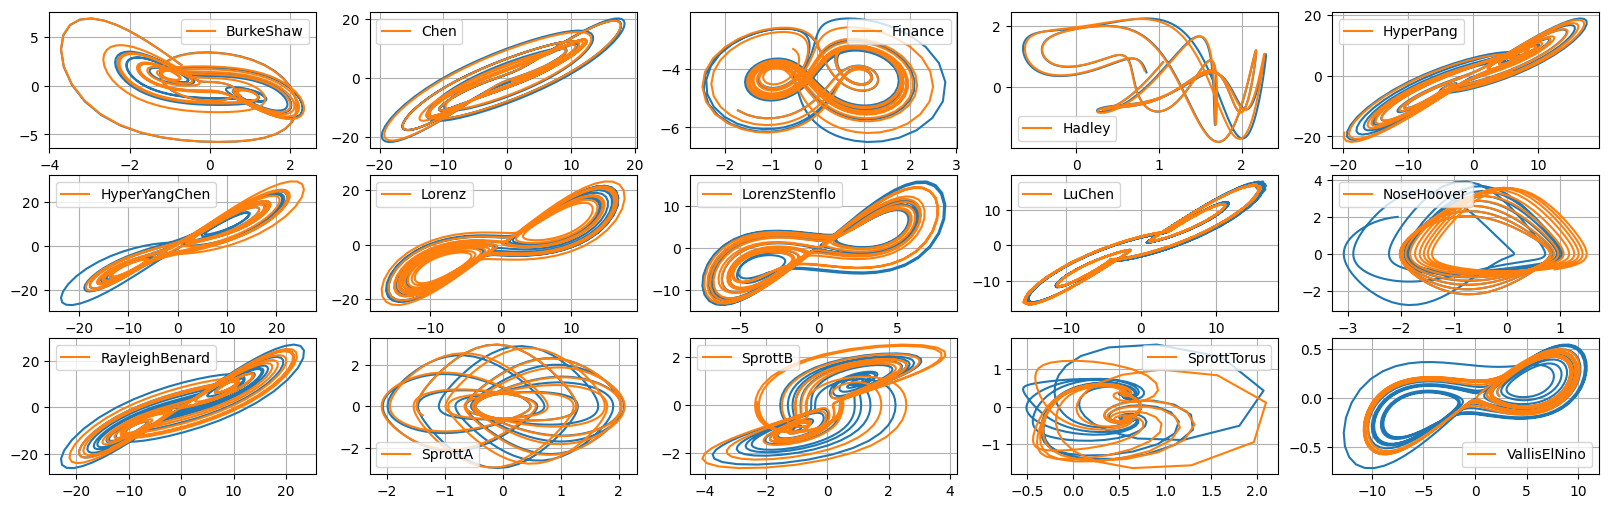

In [4]:
from scipy.optimize import dual_annealing as anneal_algo

# define hyperparameters
reg_weight_lam = 0
max_iter = 5000
eta = 1.0e3
alpha_m = 4e-2 * eta  # default is 1e-2 * eta so this speeds up the code here

# Bounds for simulated annealing
boundmax = 1000
boundmin = -1000

plt.figure(figsize=(20, 6))
for i in range(len(systems_list)):
    print(i, systems_list[i])
    r = dimension_list[i]

    # make training and testing data
    t = all_t_train[systems_list[i]][0]
    x_train = all_sols_train[systems_list[i]][0]
    x_test = all_sols_test[systems_list[i]][0]

    # run trapping SINDy
    sindy_opt = ps.TrappingSR3(
        method="global",
        _n_tgts=r,
        _include_bias=True,
        reg_weight_lam=reg_weight_lam,
        eta=eta,
        alpha_m=alpha_m,
        max_iter=max_iter,
        gamma=-0.1,
        verbose=True,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)

    # Check the model coefficients and integrate it
    Xi = model.coefficients().T
    xdot_test = model.differentiate(x_test, t=t)
    xdot_test_pred = model.predict(x_test)
    x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    # Plot the integrated trajectories from the model
    plt.subplot(3, 5, i + 1)
    plt.plot(x_test[:, 0], x_test[:, 1])
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], label=systems_list[i])
    plt.grid(True)
    plt.legend()

    check_local_stability(r, Xi, sindy_opt, 1.0)
    Xi_true = (true_coefficients[i].T)[: Xi.shape[0], :]

    # run simulated annealing on the true system to make sure the system is amenable to trapping theorem
    boundvals = np.zeros((r, 2))
    boundvals[:, 0] = boundmin
    boundvals[:, 1] = boundmax
    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    L = np.tensordot(PL_tensor, Xi_true, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PM_tensor, Xi_true, axes=([4, 3], [0, 1]))
    algo_sol = anneal_algo(
        obj_function, bounds=boundvals, args=(L, Q, np.eye(r)), maxiter=500
    )
    opt_m = algo_sol.x
    opt_energy = algo_sol.fun
    print(
        "Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 = ",
        opt_energy,
    )
    # print('Optimal m = ', opt_m, '\n')

### Verify explicitly that some of the systems have unstable invariant linear or constant subspaces
These systems are not globally stable!

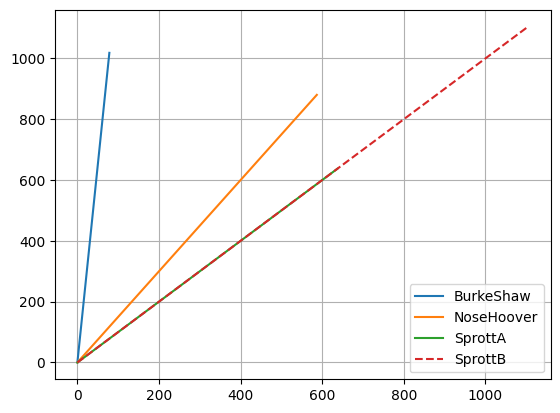

In [5]:
plt.figure()
for system in ["BurkeShaw", "NoseHoover", "SprottA", "SprottB"]:
    eq = getattr(flows, system)()
    eq.ic = np.array([0, 0, 0])
    t_sol, sol = eq.make_trajectory(
        10000,
        pts_per_period=100,
        resample=True,
        return_times=True,
        standardize=False,
    )
    style = "solid"
    if system == "SprottB":
        style = "--"

    # Show z-component flying off to infinity!
    plt.plot(t_sol, sol[:, 2], linestyle=style, label=system)

plt.grid(True)
plt.legend()

### Now repeat for locally stable models!
In practice there will be finite errors in the models that leads to a breaking of the constraint. We also check again that simulated annealing gives a negative definite $\mathbf{A}^S$ matrix with the SINDy model, not with the analytic model.

0 Finance 3
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 8.059e-02 ... 1.037e-06 ... 0.00e+00 ... 7.28e-21 ... 1.43e-09 ... 8.06e-02


optimal m:  [-0.17872293 -5.18233759 -2.00099101]
As eigvals:  [-1.09354594 -0.26927258 -0.0998163 ]
Maximum deviation from having zero totally symmetric part:  1.0895927796000848e-09
Estimate of trapping region size, Rm =  32.5655627603100
Local stability size, R_ls=  52890340.6505955
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.2258687904982091
1 Hadley 3
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.375e-02 ... 5.442e-07 ... 0.00e+00 ... 9.46e-20 ... 1.84e-10 ... 1.37e-02


optimal m:  [-1.20598029 -0.06194094 -0.21514789]
As eigvals:  [-2.3036358  -2.20355473 -0.09976027]
Maximum deviation from having zero totally symmetric part:  3.832196684516049e-10
Estimate of trapping region size, Rm =  21.3959016733596
Local stability size, R_ls=  150296596.889472
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.20090477152486969
2 Lorenz 3
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.851e+02 ... 1.125e-05 ... 0.00e+00 ... 4.85e-21 ... 4.21e-02 ... 3.85e+02


  500 ... 3.851e+02 ... 6.575e-09 ... 0.00e+00 ... 4.85e-21 ... 4.21e-02 ... 3.85e+02
 1000 ... 3.851e+02 ... 1.175e-10 ... 0.00e+00 ... 4.85e-21 ... 4.21e-02 ... 3.85e+02


 1500 ... 3.851e+02 ... 3.092e-12 ... 0.00e+00 ... 4.85e-21 ... 4.21e-02 ... 3.85e+02
 2000 ... 3.851e+02 ... 8.630e-14 ... 0.00e+00 ... 4.85e-21 ... 4.21e-02 ... 3.85e+02


optimal m:  [-1.16317593 -0.15213738 32.11743139]
As eigvals:  [-10.75415712  -2.6597302   -0.09925263]
Maximum deviation from having zero totally symmetric part:  5.822605836293592e-06
Estimate of trapping region size, Rm =  958.076326267331
Local stability size, R_ls=  8883.48531726147
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -1.0093132119107993
3 LorenzStenflo 4
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.474e+01 ... 9.025e-06 ... 0.00e+00 ... 4.79e-21 ... 5.31e-04 ... 3.47e+01


  500 ... 3.474e+01 ... 1.144e-10 ... 0.00e+00 ... 4.79e-21 ... 5.31e-04 ... 3.47e+01


optimal m:  [-1.12934737 -0.04655087 25.46967752 -1.38293936]
As eigvals:  [-2.82786453 -1.83991521 -0.69795184 -0.09957423]
Maximum deviation from having zero totally symmetric part:  7.074534447879584e-07
Estimate of trapping region size, Rm =  182.130330297890
Local stability size, R_ls=  52599.2015747807
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.7007291203642858


4 VallisElNino 3
 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.645e+00 ... 1.148e-04 ... 0.00e+00 ... 4.89e-21 ... 4.43e-08 ... 2.64e+00
  500 ... 2.645e+00 ... 3.605e-10 ... 0.00e+00 ... 4.89e-21 ... 4.49e-08 ... 2.64e+00


optimal m:  [ -1.15168077  -0.28166042 -94.83412942]
As eigvals:  [-8.45780453 -1.02479027 -0.09960374]
Maximum deviation from having zero totally symmetric part:  9.08775827404437e-09
Estimate of trapping region size, Rm =  1783.35447230267
Local stability size, R_ls=  6326096.71687962
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -1.0285328886982743


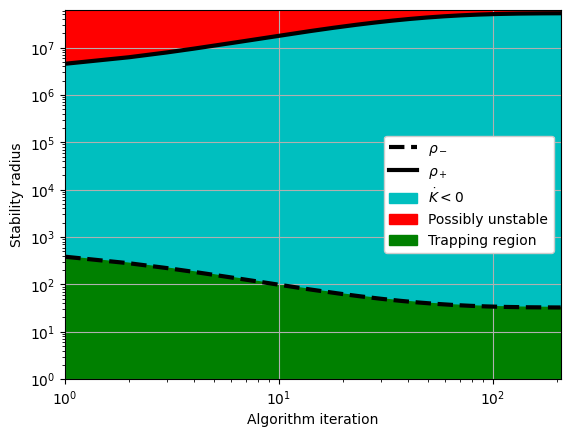

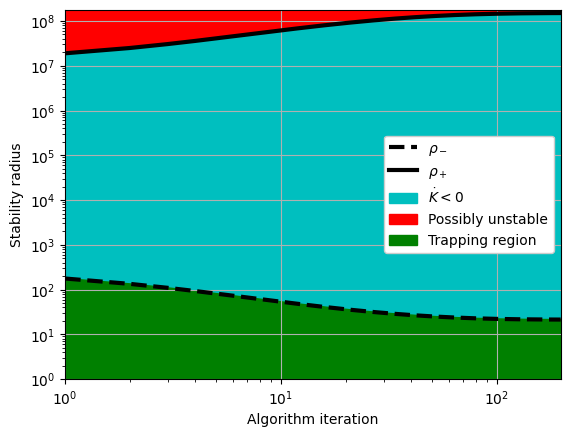

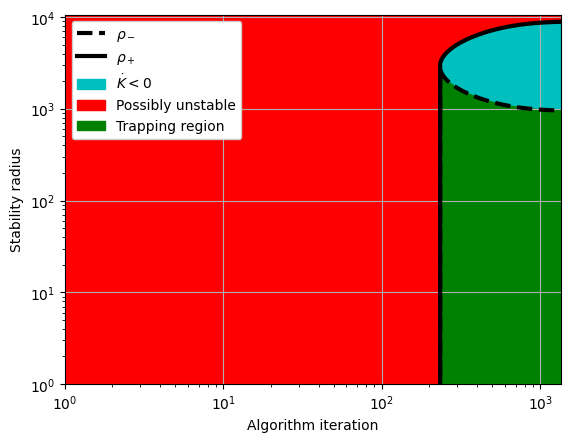

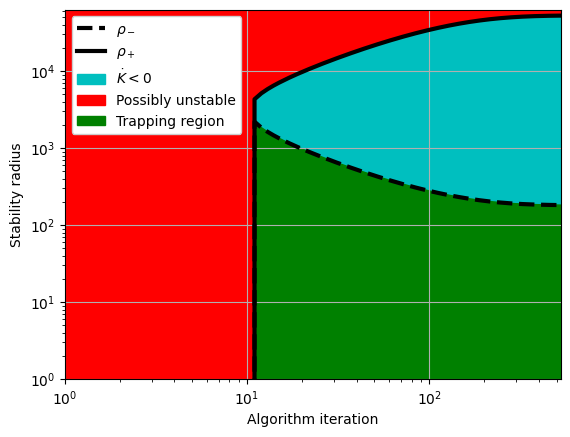

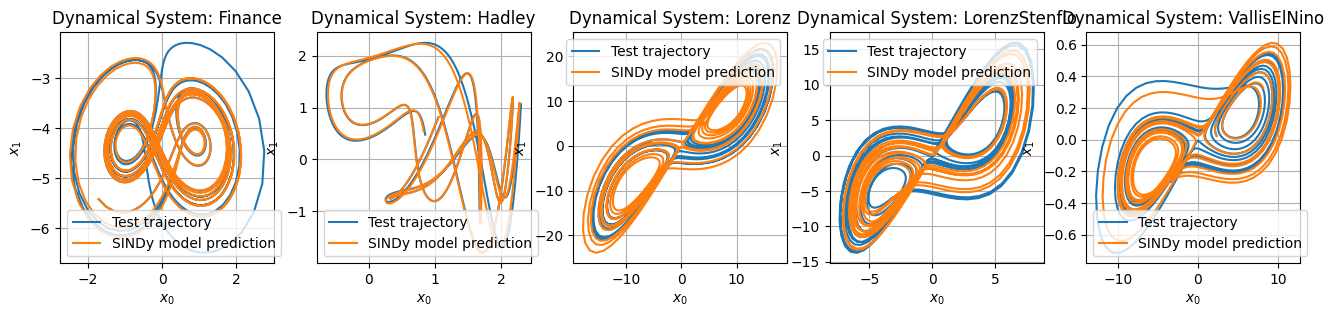

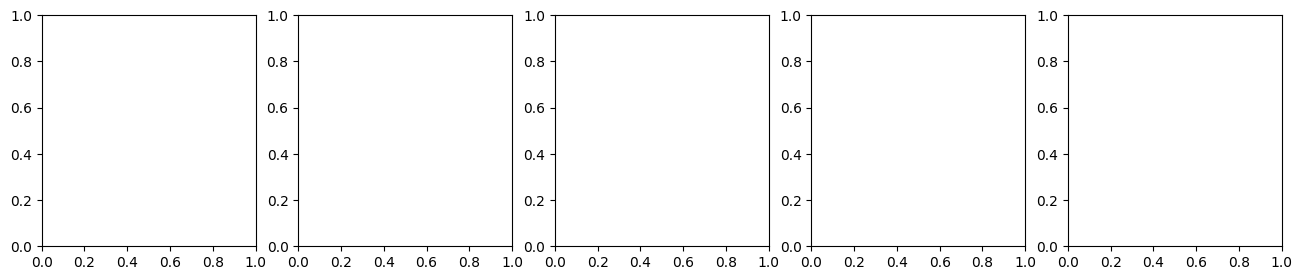

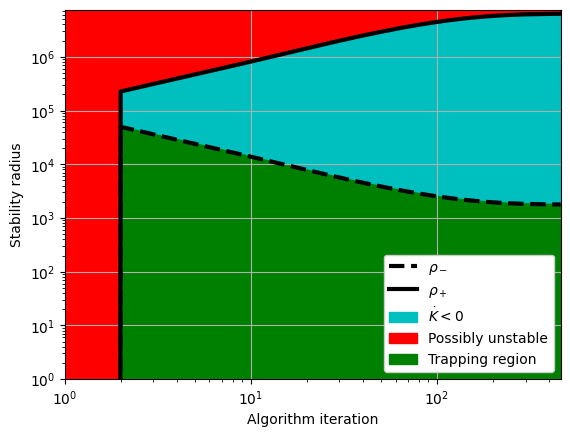

In [6]:
# define hyperparameters
reg_weight_lam = 0
max_iter = 5000
eta = 1.0e7
alpha_m = 0.1 * eta  # default is 1e-2 * eta so this speeds up the code here

stable_systems = [2, 3, 6, 7, 14]
stable_systems_list = systems_list[stable_systems]

for i in range(len(stable_systems_list)):
    plt.figure(10, figsize=(16, 3))
    r = dimension_list[stable_systems[i]]
    print(i, stable_systems_list[i], r)

    # make training and testing data
    t = all_t_train[stable_systems_list[i]][0]
    x_train = all_sols_train[stable_systems_list[i]][0]
    x_test = all_sols_test[stable_systems_list[i]][0]

    # run trapping SINDy, locally stable variant
    # where the constraints are removed and beta << 1
    sindy_opt = ps.TrappingSR3(
        method="local",
        _n_tgts=r,
        _include_bias=True,
        reg_weight_lam=reg_weight_lam,
        eta=eta,
        alpha_m=alpha_m,
        max_iter=max_iter,
        gamma=-0.1,
        verbose=True,
        beta=1e-9,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)

    # Check the model coefficients and integrate it
    Xi = model.coefficients().T
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    xdot_test = model.differentiate(x_test, t=t)
    xdot_test_pred = model.predict(x_test)
    x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    # Check stability and try simulated annealing with the IDENTIFIED model
    check_local_stability(r, Xi, sindy_opt, 1.0)
    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PM_tensor, Xi, axes=([4, 3], [0, 1]))
    boundvals = np.zeros((r, 2))
    boundvals[:, 0] = boundmin
    boundvals[:, 1] = boundmax

    # run simulated annealing on the IDENTIFIED system
    algo_sol = anneal_algo(
        obj_function, bounds=boundvals, args=(L, Q, np.eye(r)), maxiter=500
    )
    opt_m = algo_sol.x
    opt_energy = algo_sol.fun
    print(
        "Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 = ",
        opt_energy,
    )
    # print('Optimal m = ', opt_m, '\n')
    plt.subplot(1, 5, i + 1)
    plt.title("Dynamical System: " + stable_systems_list[i])
    plt.plot(x_test[:, 0], x_test[:, 1], label="Test trajectory")
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], label="SINDy model prediction")
    plt.grid(True)
    plt.xlabel(r"$x_0$")
    plt.ylabel(r"$x_1$")
    plt.legend()

    # Plot the rho_+ and rho_- estimates for the stable systems
    plt.figure(11, figsize=(16, 3))
    plt.subplot(1, 5, i + 1)
    rhos_minus, rhos_plus = make_trap_progress_plots(r, sindy_opt)
    plt.yscale("log")
    plt.ylim(1, rhos_plus[-1] * 1.2)

### Last demonstration: building locally stable reduced-order models for the lid-cavity flow
First we compute a Galerkin model at different levels of truncation. This is also done in the Example 14 Jupyter notebook so we gloss over the description here.

In [7]:
from scipy.io import loadmat

data = loadmat("../data/cavityPOD.mat")
t_dns = data["t"].flatten()
a_dns = data["a"]

# Downsample the data
skip = 1
t_dns = t_dns[::skip]
a_dns = a_dns[::skip, :]
dt_dns = t_dns[1] - t_dns[0]
singular_vals = data["svs"].flatten()


class GalerkinROM:
    def __init__(self, file):
        model_dict = loadmat(file)
        self.C = model_dict["C"][0]
        self.L = model_dict["L"]
        self.Q = model_dict["Q"]

    def integrate(self, x0, t, r=None, rtol=1e-3, atol=1e-6):
        if r is None:
            r = len(self.C)

        # Truncate model as indicated
        C = self.C[:r]
        L = self.L[:r, :r]
        Q = self.Q[:r, :r, :r]

        # RHS of POD-Galerkin model, for time integration
        def rhs(t, x):
            return C + (L @ x) + np.einsum("ijk,j,k->i", Q, x, x)

        sol = solve_ivp(rhs, (t[0], t[-1]), x0[:r], t_eval=t, rtol=rtol, atol=atol)
        return sol.y.T


# Simulate Galerkin system at various truncation levels
galerkin_model = GalerkinROM("../data/cavityGalerkin.mat")

dt_rom = 1e-2
t_sim = np.arange(0, 300, dt_rom)

a0 = a_dns[0, :]

# Finally, build a r=6 and r=16 Galerkin model
a_gal6 = galerkin_model.integrate(a0, t_sim, r=6, rtol=1e-8, atol=1e-8)
a_gal16 = galerkin_model.integrate(a0, t_sim, r=16, rtol=1e-8, atol=1e-8)

### Now try building a locally stable trapping SINDy model now
It does not quite achieve the negative definite stability matrix, but it performs remarkably well.

In [8]:
r = 6  # POD truncation

x_train = a_dns[:, :r]
t_train = t_dns.copy()

reg_weight_lam = 0.0
eta = 1.0e10
alpha_m = 1e-4 * eta  # default is 1e-2 * eta so this speeds up the code here
beta = 1e-5
max_iter = 100
sindy_opt = ps.TrappingSR3(
    method="local",
    _n_tgts=r,
    _include_bias=True,
    reg_weight_lam=reg_weight_lam,
    eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    gamma=-0.1,
    verbose=True,
    beta=beta,
)

# Fit the model
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)

model.fit(x_train, t=t_train)
Xi = model.coefficients().T
check_local_stability(r, Xi, sindy_opt, 1.0)

# Fit a baseline model -- this is almost always an unstable model!
model_baseline = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.0),
    feature_library=ps.PolynomialLibrary(),
)
model_baseline.fit(x_train, t=t_train)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:


    0 ... 4.580e-01 ... 1.374e-06 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
   10 ... 4.580e-01 ... 4.848e-08 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
   20 ... 4.580e-01 ... 2.250e-08 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
   30 ... 4.580e-01 ... 1.556e-08 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01


   40 ... 4.580e-01 ... 1.184e-08 ... 0.00e+00 ... 2.26e-16 ... 1.92e-10 ... 4.58e-01
   50 ... 4.580e-01 ... 9.495e-09 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
   60 ... 4.580e-01 ... 7.904e-09 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
   70 ... 4.580e-01 ... 6.766e-09 ... 0.00e+00 ... 2.26e-16 ... 1.92e-10 ... 4.58e-01


   80 ... 4.580e-01 ... 5.919e-09 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
   90 ... 4.580e-01 ... 5.267e-09 ... 0.00e+00 ... 2.26e-16 ... 1.92e-10 ... 4.58e-01
optimal m:  [-0.09990992  0.46717874  0.10699607 -0.10719345 -1.25827069 -1.31953615]
As eigvals:  [-70.57503697 -69.281563   -24.95987675  -7.10842051   1.30184467
   9.54514126]
Maximum deviation from having zero totally symmetric part:  1.032609731055345e-08
Estimate of trapping region size, Rm =  -188686364.891334
Local stability size, R_ls=  -3.50523751717947


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'],
      optimizer=STLSQ(threshold=0.0))

In [9]:
# Simulate the model
a_sindy = model.simulate(a0[:r], t_sim)
a_sindy_baseline = model_baseline.simulate(a0[:r], t_sim, integrator="odeint")

rE = 16
E_sindy = np.sum(a_sindy[:, :rE] ** 2, 1)
E_sindy_baseline = np.sum(a_sindy_baseline[:, :rE] ** 2, 1)
E_dns = np.sum(a_dns[:, :rE] ** 2, 1)
E_gal6 = np.sum(a_gal6[:, :rE] ** 2, 1)
E_gal16 = np.sum(a_gal16[:, :rE] ** 2, 1)

### Now we plot the trajectories and energy as function of time
Trapping SINDy model vastly outperforms the Galerkin models!

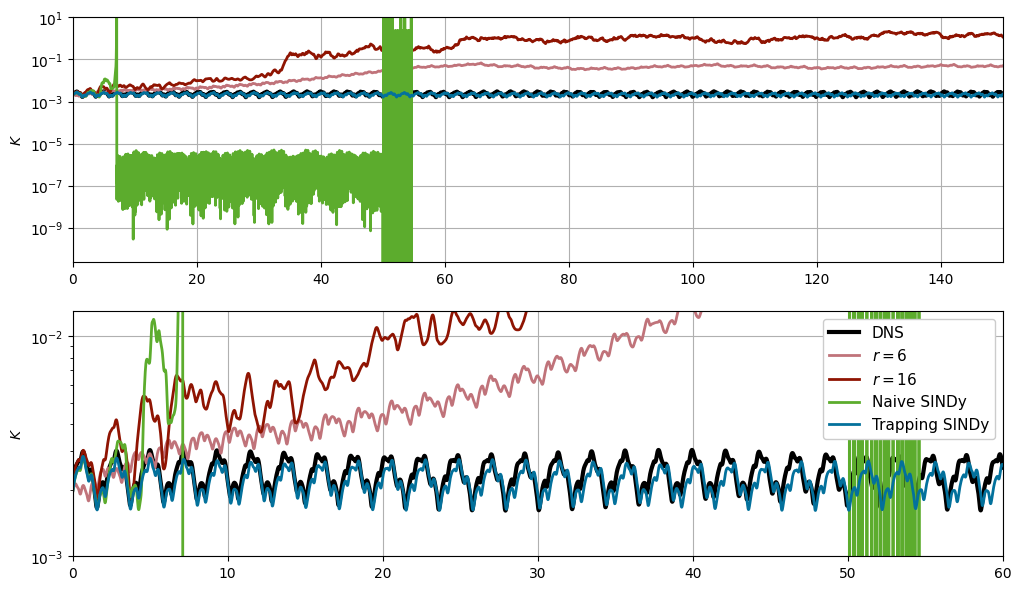

In [10]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(t_dns, E_dns, "k", label="DNS", lw=3)
plt.plot(t_sim, E_gal6, label="$r=6$", lw=2, c="xkcd:dusty rose")
plt.plot(t_sim, E_gal16, label="$r=16$", lw=2, c="xkcd:brick red")
plt.plot(t_sim, E_sindy_baseline, label="Naive SINDy", lw=2, c="xkcd:grass")
plt.plot(t_sim, E_sindy, label="Trapping SINDy", lw=2, c="xkcd:ocean blue")
plt.gca().set_yscale("log")
plt.ylabel("$K$")
plt.ylim([0, 10])
plt.xlim([0, 150])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_dns, E_dns, "k", label="DNS", lw=3)
plt.plot(t_sim, E_gal6, label="$r=6$", lw=2, c="xkcd:dusty rose")
plt.plot(t_sim, E_gal16, label="$r=16$", lw=2, c="xkcd:brick red")
plt.plot(t_sim, E_sindy_baseline, label="Naive SINDy", lw=2, c="xkcd:grass")
plt.plot(t_sim, E_sindy, label="Trapping SINDy", lw=2, c="xkcd:ocean blue")
plt.gca().set_yscale("log")
plt.legend(loc=1, fancybox=True, framealpha=1, fontsize=11)
plt.ylabel("$K$")
plt.ylim([1e-3, 1.3e-2])
plt.xlim([0, 60])
# plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.savefig("cavity_plot.pdf")

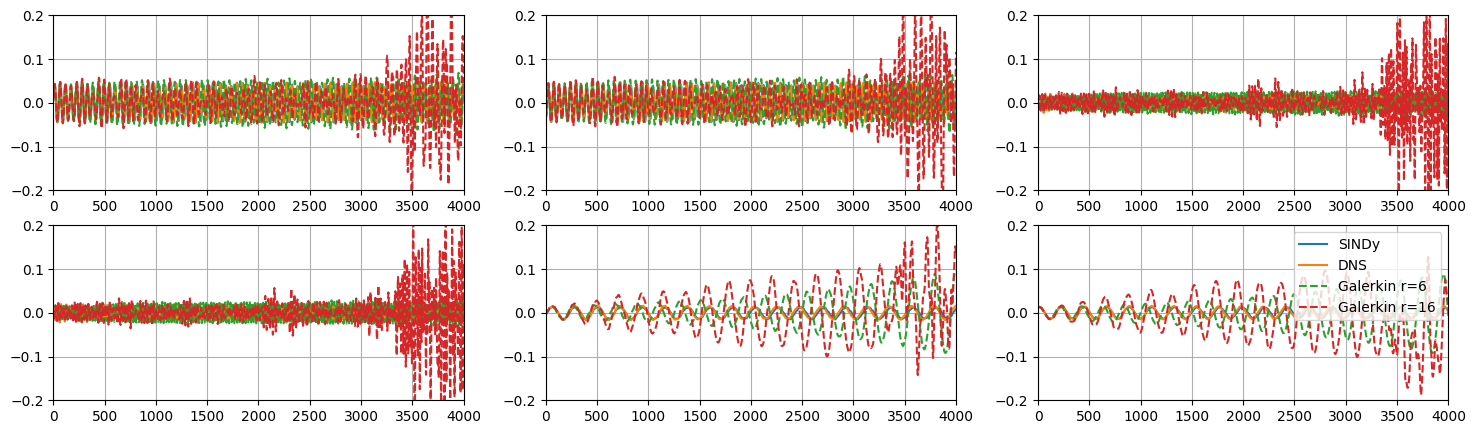

In [11]:
plt.figure(figsize=(18, 5))
for i in range(r):
    plt.subplot(2, r // 2, i + 1)
    plt.plot(a_sindy[:, i], label="SINDy")
    plt.plot(a_dns[:, i], label="DNS")
    plt.plot(a_gal6[:, i], "--", label="Galerkin r=6")
    plt.plot(a_gal16[:, i], "--", label="Galerkin r=16")
    if i == r - 1:
        plt.legend()
    plt.grid()
    plt.xlim(0, 4000)
    plt.ylim(-0.2, 0.2)

### Last check: Trapping SINDy model reproduces the power spectral density of the data

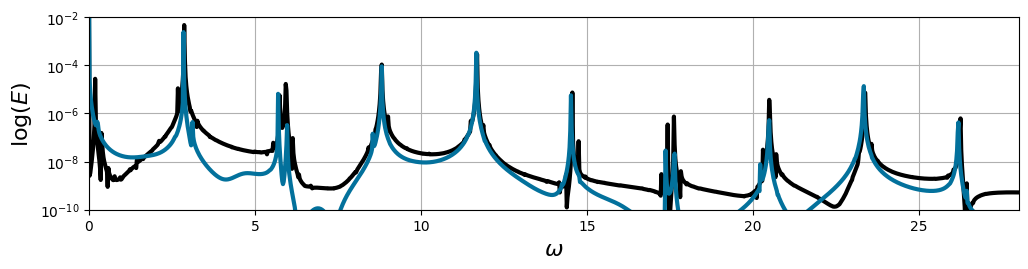

In [12]:
# Basic power spectral density estimate using FFT
def psd_est(E, dt=1):
    Ehat = np.abs((dt * np.fft.fft(E)) ** 2)
    Ehat = Ehat[: int(len(Ehat) / 2)]
    N = len(Ehat)
    freq = 2 * np.pi * np.arange(N) / (2 * dt * N)  # Frequencies in rad/s
    return Ehat, freq


psd, freq = psd_est(E_dns, dt=t_dns[1] - t_dns[0])
psd_sim, freq_sim = psd_est(E_sindy, dt=t_sim[1] - t_sim[0])

plt.figure(figsize=(12, 2.5))
plt.semilogy(freq, psd, "k", lw=3)
plt.semilogy(freq_sim, psd_sim, "xkcd:ocean blue", lw=3)
plt.xlim([0, 28])
plt.ylim([1e-10, 1e-2])
plt.xlabel(r"$\omega$", fontsize=16)
plt.ylabel(r"$\log(E)$", fontsize=16)
plt.grid()
plt.show()